In [1]:
import numpy as np
import pandas as pd
import shap

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap

from xgboost import XGBRegressor

In [2]:
anaemia_full=pd.read_excel('c:\\Anaemia-Ashleigh\\anaemia_data_knime.xlsx')
anaemia_full.head()


,Site,Date,Dataset No.,Dataset_Name,Diagnosis,Fish No.,Length (cm),Avg Weight (g),AGD,PGD,...,Mg mmol/L,P mmol/L,K mmol/L,TP g/L,Na mmol/L,Zn umol/L,Aldolase u/L,Ammonia umol/L,CK-MB u/L,CO2 mmol/L
0,Ardintoul,171019,1,Dataset1,Amber,1,NaN,1900,1.5,1.6,...,1.32,4.93,1.95,42.1,261.3,300.66,98.7,667.8,11440.0,9.7
1,Ardintoul,171019,2,Dataset1,Amber,2,NaN,1900,1.5,1.6,...,NaN,5.98,2.55,50.6,271.7,NaN,111.0,774.2,11740.0,NaN
2,Ardintoul,171019,3,Dataset1,Red,3,NaN,1900,1.5,1.6,...,1.37,4.89,2.03,41.3,261.8,206.80,62.0,713.6,5700.0,11.8
3,Ardintoul,171019,4,Dataset1,Red,4,NaN,1900,1.5,1.6,...,NaN,5.38,2.70,41.4,268.1,257.13,117.0,839.5,12880.0,NaN
4,Ardintoul,171019,5,Dataset1,Red,5,NaN,1900,1.5,1.6,...,1.64,6.42,2.42,44.5,264.8,318.22,80.3,891.7,6520.0,12.9


In [3]:
y = anaemia_full['Diagnosis']
y.head()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

0    Amber
1    Amber
2      Red
3      Red
4      Red
Name: Diagnosis, dtype: object

In [18]:
# X=anaemia_full.drop({['Diagnosis'],['Dataset No.'],['Fish No.'],['Date']}, axis=1)
X=anaemia_full.drop(['Site','Diagnosis','Dataset No.','Fish No.','Dataset_Name','Date','Length (cm)', 'Hct Cent'], axis=1)

In [19]:
#X.isnull().sum().sum()
#X.isnull().mean()
pct_null =X.isnull().sum() / len(X)
missing_features = pct_null[pct_null > 0.65].index
print(missing_features)


Index(['WBC 10^3 uL', 'M', 'Albumin g/L', 'Amalyse u/L', 'TBIL umol/L',
       'Ca mmol/L', 'Cu umol/L', 'Lactate mmol/L', 'Mg mmol/L', 'P mmol/L',
       'TP g/L', 'Zn umol/L', 'Aldolase u/L', 'Ammonia umol/L', 'CO2 mmol/L'],
      dtype='object')


In [20]:
X.drop(missing_features, axis=1, inplace=True)
X.describe()


,Avg Weight (g),AGD,PGD,SW Temp,Hb Db,RBC count,TRBC 10^6 uL,Immature RBC,Retic (%),Absolute Retic Count (thou/uL),...,TAS mmol/L,ALT Mono u/L,ALP u/L,AST Mono u/L,Cl mmol/L,CK u/L,LDH u/L,K mmol/L,Na mmol/L,CK-MB u/L
count,78.000000,78.000000,78.000000,78.000000,75.000000,73.000000,73.000000,73.000000,73.000000,73.000000,...,40.00000,38.000000,38.000000,37.000000,28.000000,34.000000,35.000000,29.000000,33.000000,28.000000
mean,3389.743590,0.653846,1.987179,11.871795,6.785333,71.095890,1.422192,28.082192,0.280411,155.712329,...,1.53425,11.292105,455.665789,377.467568,106.925000,4823.488235,517.031429,2.548621,261.239394,12325.714286
std,884.731927,0.651211,0.964885,0.795425,3.201200,21.652665,0.433148,21.340333,0.213635,58.310386,...,0.24294,4.541007,134.682119,94.302248,4.638776,2523.387352,353.345026,0.498768,4.942225,11870.075487
min,1900.000000,0.000000,0.000000,11.000000,0.110000,4.000000,0.080000,5.000000,0.050000,38.400000,...,0.93000,5.800000,221.000000,205.600000,93.800000,-51.100000,183.000000,1.950000,247.700000,4100.000000
25%,2375.000000,0.000000,1.600000,11.000000,4.885000,65.000000,1.300000,15.000000,0.150000,120.400000,...,1.40000,8.850000,361.100000,303.400000,104.325000,3015.250000,296.850000,2.210000,258.800000,6360.000000
50%,3800.000000,1.000000,2.000000,12.000000,6.390000,78.000000,1.560000,20.000000,0.200000,147.600000,...,1.57000,10.700000,437.350000,369.800000,106.250000,4510.250000,383.200000,2.420000,261.100000,9760.000000
75%,4000.000000,1.375000,2.000000,12.750000,8.665000,85.000000,1.700000,36.000000,0.360000,197.100000,...,1.70250,12.250000,533.875000,429.100000,110.800000,6381.050000,553.450000,2.760000,264.300000,15135.000000
max,4000.000000,1.500000,4.000000,13.000000,19.440000,95.000000,1.900000,96.000000,0.960000,319.200000,...,1.97000,33.900000,733.900000,536.400000,115.500000,9291.100000,1618.900000,4.390000,271.700000,67760.000000


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


In [41]:
X_test.head(20)

,Avg Weight (g),AGD,PGD,SW Temp,Hb Db,RBC count,TRBC 10^6 uL,Immature RBC,Retic (%),Absolute Retic Count (thou/uL),...,TAS mmol/L,ALT Mono u/L,ALP u/L,AST Mono u/L,Cl mmol/L,CK u/L,LDH u/L,K mmol/L,Na mmol/L,CK-MB u/L
23,3800,0.0,0.0,12,3.95,82.0,1.64,18.0,0.18,147.6,...,1.26,12.1,221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,1900,1.5,1.6,13,4.40,34.0,0.68,66.0,0.66,224.4,...,1.37,9.8,615.7,466.7,111.1,5103.0,353.2,2.33,267.9,7900.0
14,1900,1.5,1.6,13,5.30,48.0,0.96,52.0,0.52,249.6,...,1.74,12.1,642.8,455.7,105.3,8284.8,486.7,2.32,262.6,18220.0
62,4000,0.0,2.0,11,9.00,80.0,1.60,9.0,0.09,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1900,1.5,1.6,13,5.00,63.0,1.26,37.0,0.37,233.1,...,1.85,33.9,629.1,303.4,108.0,NaN,431.5,4.39,261.6,67760.0
37,3800,0.0,0.0,12,4.91,85.0,1.70,15.0,0.15,127.5,...,1.55,12.3,428.7,425.7,112.6,NaN,620.2,2.73,260.9,NaN
72,4000,0.0,2.0,11,11.17,75.0,1.50,25.0,0.25,187.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,4000,0.0,2.0,11,13.76,81.0,1.62,19.0,0.19,153.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,3800,0.0,3.5,12,4.38,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1900,1.5,1.6,13,NaN,37.0,0.74,63.0,0.63,233.1,...,1.91,10.6,705.8,353.1,113.3,5458.8,436.1,2.49,271.0,11040.0


In [43]:
print(y_test)

[0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 2 0 0]


In [22]:
from sklearn.preprocessing import LabelEncoder
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)


In [23]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
xgb.feature_importances_

array([1.68201271e-02, 9.55373049e-03, 6.97866501e-03, 0.00000000e+00,
       9.44193900e-02, 1.54305855e-02, 1.09745061e-03, 1.07825006e-04,
       0.00000000e+00, 9.82344354e-05, 5.95676005e-02, 6.61083460e-02,
       8.09233810e-04, 5.60148546e-05, 5.03446274e-02, 6.07799564e-04,
       7.34261796e-02, 1.72863627e-04, 7.01376848e-05, 6.13518246e-02,
       3.34862471e-01, 3.63666564e-02, 4.04000841e-03, 4.76179586e-04,
       2.22630869e-03, 1.60545617e-01, 9.86276777e-04, 3.20941000e-03,
       1.20618337e-04, 1.45874554e-04], dtype=float32)

In [34]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

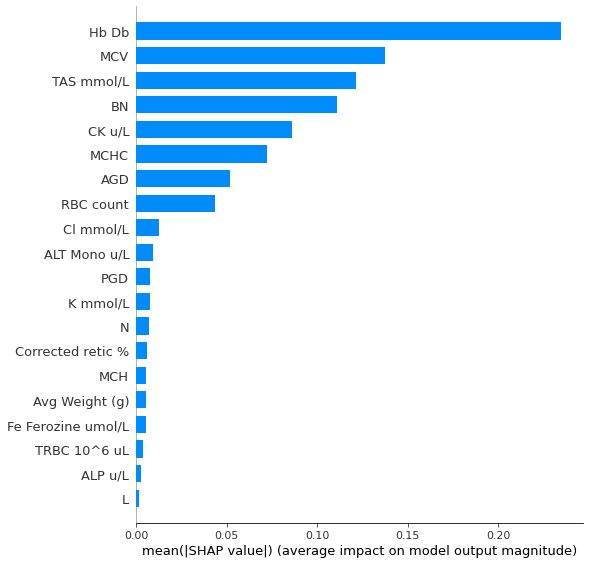

In [35]:
#SHAP (SHapley Additive exPlanations)
shap.summary_plot(shap_values, X_test, plot_type="bar")

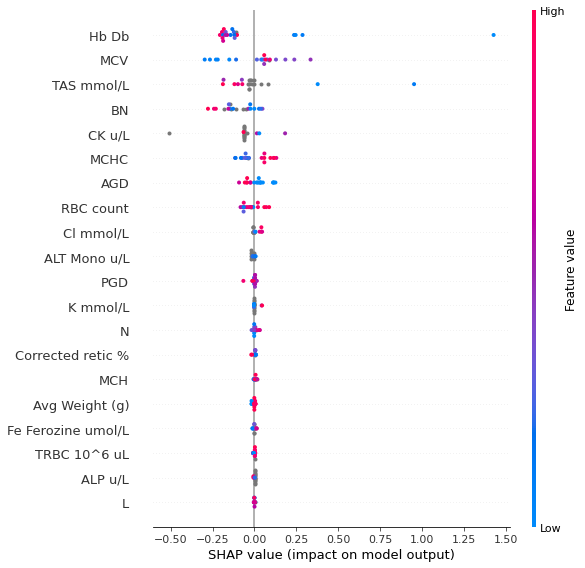

In [36]:

shap.summary_plot(shap_values, X_test)

<BarContainer object of 30 artists>

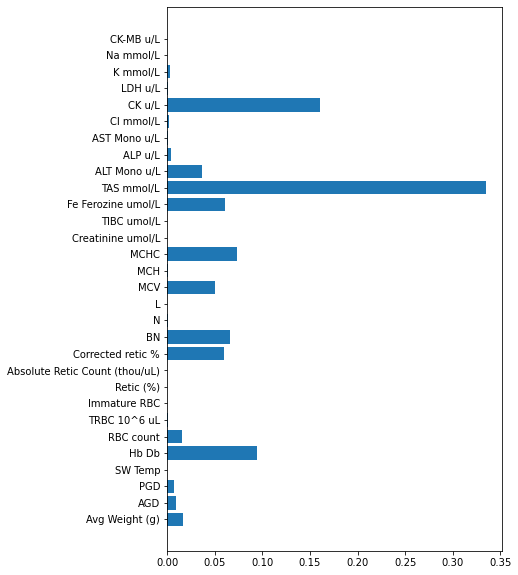

In [27]:
import matplotlib.cm as cm
cmap=cm.autumn
plt.figure(figsize=(6,10))
plt.barh(X.columns, xgb.feature_importances_)

In [28]:
perm_importance = permutation_importance(xgb, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

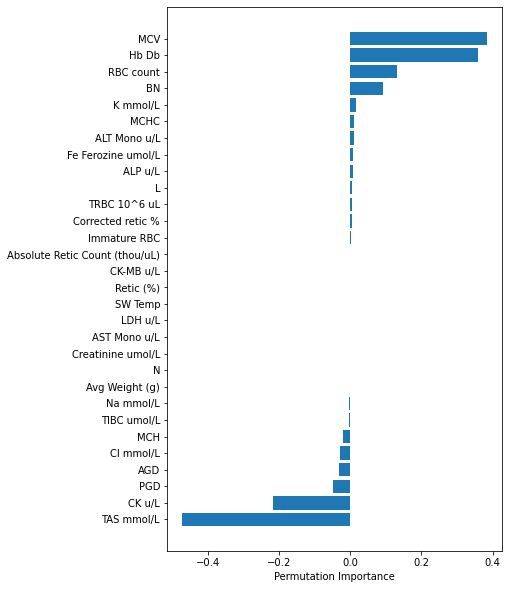

In [30]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6,10))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

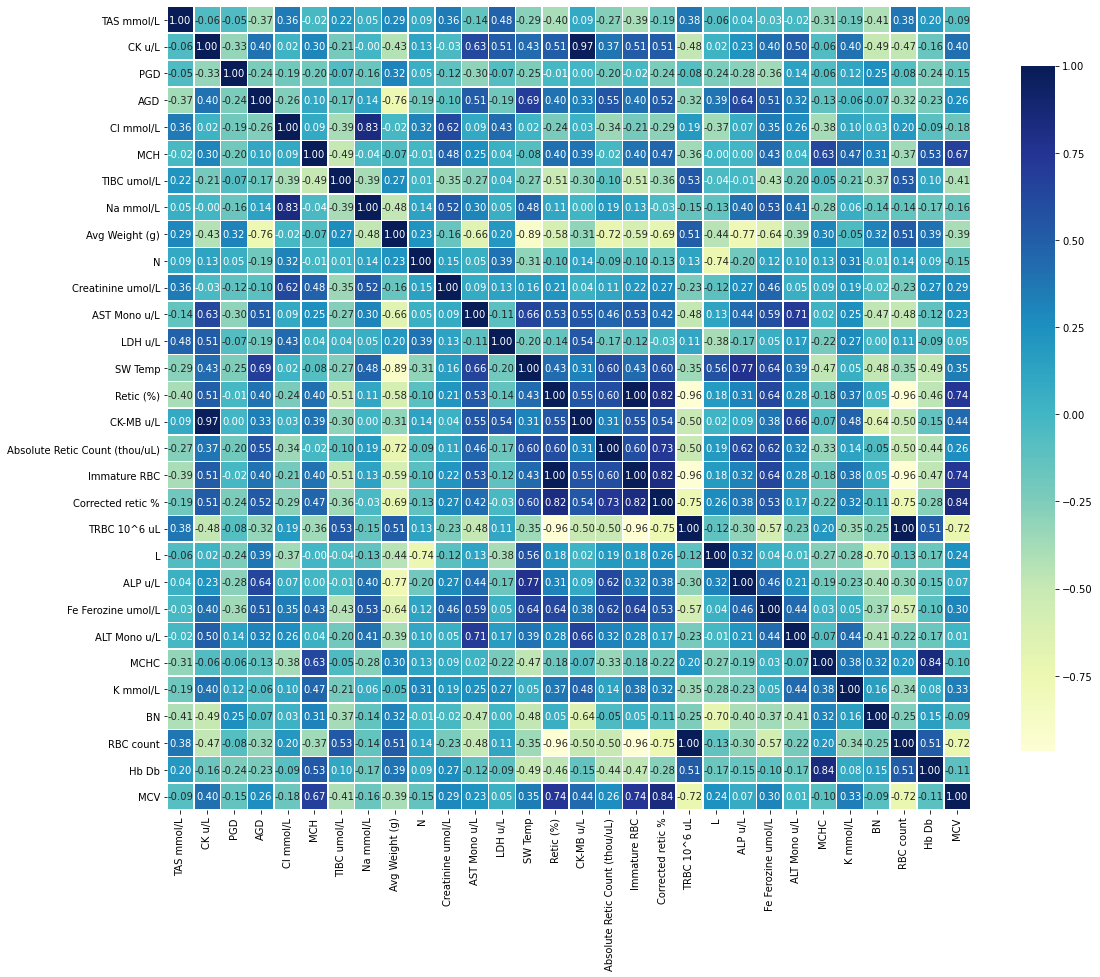

In [33]:
#The permutation based method can have problem with highly-correlated features. Let’s check the correlation in our dataset:

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X_train[X.columns[sorted_idx]])

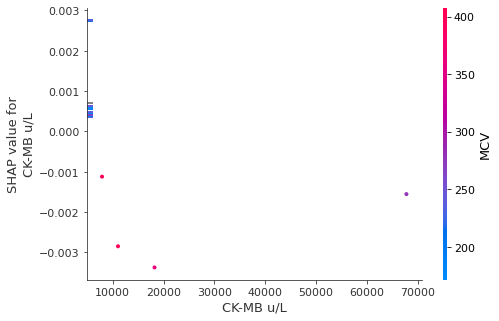

In [45]:
shap.dependence_plot(29,shap_values, X_test)